<a href="https://colab.research.google.com/github/TamarSdeChen/Self-Learner-DeepLearning-Course-Technion/blob/main/BYOL_feature_extruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install lightly

In [9]:
import copy
import time
import os
import torch
import torchvision
import numpy as np
from torch import nn

from matplotlib import pyplot as plt

from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import BYOLPredictionHead, BYOLProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.simclr_transform import SimCLRTransform
from lightly.utils.scheduler import cosine_schedule

In [10]:
class BYOL(nn.Module):
  def __init__(self, backbone):
    super().__init__()
    self.backbone = backbone # e.g., resnet - REPRESENTATION
    self.projection_head = BYOLProjectionHead(512, 1024, 256)
    self.prediction_head = BYOLPredictionHead(256, 1024, 256)
    self.backbone_momentum = copy.deepcopy(self.backbone)
    self.projection_head_momentum = copy.deepcopy(self.projection_head)
    deactivate_requires_grad(self.backbone_momentum)
    deactivate_requires_grad(self.projection_head_momentum)

  def forward(self, x):
    y = self.backbone(x).flatten(start_dim=1)
    z = self.projection_head(y)
    p = self.prediction_head(z)
    return p
  def forward_momentum(self, x):
    y = self.backbone_momentum(x).flatten(start_dim=1)
    z = self.projection_head_momentum(y)
    z = z.detach()
    return z

In [11]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# initialization example
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BYOL(backbone)

In [14]:
# if using the pre-trained beckbone: your input = True else False
pre_trained = input()
if pre_trained == "True":
  path_to_weights = 'pre_trained_backbone_BYOL_checkpoint.pth'
else:
  path_to_weights = 'BYOL_checkpoint.pth'

False


In [15]:
state = torch.load(path_to_weights)
model.load_state_dict(state['net'])
model.to(device)

BYOL(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [16]:
from torchvision.datasets import STL10
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

# tansform
# create the data set for get image representation

# in the pipe the STL10 images will not augmantated, we will just get the representation for the original image
# so we dont use augmatation, check if we need to normalize and resize
train_labeled_dataset = STL10(root="data", split="train", download=True, transform=ToTensor())
train_labeled_loader = torch.utils.data.DataLoader(
    train_labeled_dataset,
    batch_size=256,
    shuffle=False,
)

100%|██████████| 2640397119/2640397119 [02:32<00:00, 17365616.63it/s]


Extracting data/stl10_binary.tar.gz to data


In [17]:
# the pipe:
# 1. test labeled images go trough BYOL
# 2. the representation pass to small MLP predictor

def get_representation(model, dataloader, device=torch.device('cuda:0')):
  model.eval() # put in evaluation mode
  representations = []
  projections = []
  labels = []
  with torch.no_grad():
    for data in dataloader:
      images, label = data
      images = images.to(device)
      label = label.to(device)

      representation = model.backbone(images).flatten(start_dim=1) # check if it is ok
      representations.append(representation)

      projection = model.projection_head(representation)
      projections.append(projection)



      labels.append(label.cpu())
    representations = torch.cat(representations)
    projections = torch.cat(projections)
    labels = torch.cat(labels)


  return representations.detach(), projections.detach(), labels.detach()


In [18]:
representation, projections, labels = get_representation(model, train_labeled_loader, device=torch.device('cuda:0'))

In [19]:
from torch.utils.data import Dataset
class CreateDataset(Dataset):
    def __init__(self, X, y):
        # convert into PyTorch tensors and remember them
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = y

    def __len__(self):
        # this should return the size of the dataset
        return len(self.X)

    def __getitem__(self, idx):
        # this should return one sample from the dataset
        features = self.X[idx]
        target = self.y[idx]
        return features, target

In [20]:
train_loder_representation = torch.utils.data.DataLoader(CreateDataset(representation,labels), batch_size=256)
train_loder_projections = torch.utils.data.DataLoader(CreateDataset(projections,labels), batch_size=256)

<ipython-input-19-ddded19db13d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


In [21]:
class BYOL_FC(nn.Module):
  def __init__(self, representation_size, hidden_size, num_clases,num_init_w):
        super(BYOL_FC, self).__init__()
        self.linear1 = nn.Linear(representation_size, hidden_size)
        self.relu = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(hidden_size, num_clases)
        #self.linear3 = nn.Linear(hidden_size, num_clases)
        self.init_weights(num_init_w)

  def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        # no softmax in the end when using crossentropy loss

        return out

  def init_weights(self, num_init_w):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        if (num_init_w == 0):
          nn.init.xavier_uniform_(m.weight)
        else:
          nn.init.normal_(m.weight, 0, 0.005)


In [22]:
# hyper-parameters
learning_rate = 1e-4
num_epochs = 1000

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# build our model and send it to the device
model_fc = BYOL_FC(representation_size=512, hidden_size=128, num_clases=10, num_init_w=0).to(device)
optimizer = torch.optim.Adam(model_fc.parameters(), lr=learning_rate)

In [23]:
# trining loop
avg_epoch_losses = []
for epoch in range(num_epochs):
  total_loss = 0
  epoch_losses = []
  model_fc.train() # change the mode to training, activating layers like DropOut and BatchNorm, if there are any


  for batch, labels in train_loder_representation:
    # send data to device
    batch = batch.to(device)
    labels = labels.to(device)
    # forward pass
    output = model_fc(batch)

    # loss
    loss = criterion(output, labels)
    total_loss += loss.detach()
    epoch_losses.append(loss.item())

    # backward pass
    optimizer.zero_grad() # clean the gradients from previous iteration
    loss.backward() # autograd backward to calculate gradients
    optimizer.step() # apply update to the weights

  if epoch % 50 == 0:
    avg_loss = total_loss / len(train_loder_representation)
    avg_epoch_losses.append(avg_loss)
    log = "Epoch: {} | Loss: {:.4f}".format(epoch, avg_loss)
    print(log)

Epoch: 0 | Loss: 2.3499
Epoch: 50 | Loss: 0.8389
Epoch: 100 | Loss: 0.7485
Epoch: 150 | Loss: 0.6898
Epoch: 200 | Loss: 0.6440
Epoch: 250 | Loss: 0.6049
Epoch: 300 | Loss: 0.5716
Epoch: 350 | Loss: 0.5422
Epoch: 400 | Loss: 0.5152
Epoch: 450 | Loss: 0.4905
Epoch: 500 | Loss: 0.4676
Epoch: 550 | Loss: 0.4463
Epoch: 600 | Loss: 0.4262
Epoch: 650 | Loss: 0.4068
Epoch: 700 | Loss: 0.3886
Epoch: 750 | Loss: 0.3713
Epoch: 800 | Loss: 0.3547
Epoch: 850 | Loss: 0.3388
Epoch: 900 | Loss: 0.3236
Epoch: 950 | Loss: 0.3091


<function matplotlib.pyplot.show(close=None, block=None)>

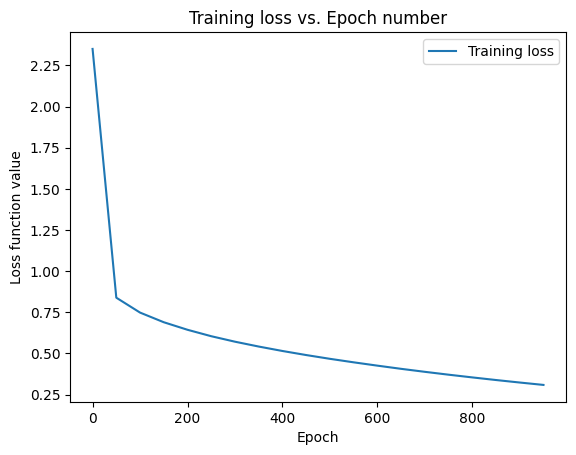

In [24]:
epoch_num = np.arange(0, 1000, 50, dtype=int)
plt.plot(epoch_num, torch.as_tensor(avg_epoch_losses).cpu(), label='Training loss')
plt.ylabel('Loss function value')
plt.xlabel('Epoch')
plt.title('Training loss vs. Epoch number')
plt.legend()

plt.show

In [25]:
# test our Fully Coneected Net
# first - create the dataset: test STL10 images and labels

test_labeled_dataset = STL10(root="data", split="test", download=True, transform=ToTensor())
test_labeled_loader = torch.utils.data.DataLoader(
    test_labeled_dataset,
    batch_size=256,
    shuffle=False,
)

# second - pass trousg the trained BYOL
representation_test ,projection_test, labels_test  = get_representation(model, test_labeled_loader, device=torch.device('cuda:0'))

# third - create the dataset for our BYOP_FC network: representation vector and labels
test_loder_projection = torch.utils.data.DataLoader(CreateDataset(representation_test,labels_test), batch_size=256)


Files already downloaded and verified


<ipython-input-19-ddded19db13d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


In [26]:
def eval_BYOL_FC(model, dataloader, device=torch.device('cuda:0')):
  model.eval() # put in evaluation mode
  model_output = []
  labels = []
  num_samples = 0
  num_correct = 0
  with torch.no_grad():
    for data in dataloader:
      representation, label = data
      representation = representation.to(device)
      label = label.to(device)
      output = model(representation)
      model_output.append(output)
      labels.append(label.cpu())

      # values, index
      _, predictions = torch.max(output,1)
      num_samples += label.shape[0]
      num_correct += (predictions == label).sum().item()
    print(num_samples,num_correct)
    accuracy = 100.0 * (num_correct / num_samples)
    print('test accuracy = {}'.format(accuracy))
    model_output = torch.cat(model_output)
    labels = torch.cat(labels)

  return model_output.detach(), labels.detach()

In [27]:
model_output, labels = eval_BYOL_FC(model_fc, test_loder_projection, device=torch.device('cuda:0'))

8000 5771
test accuracy = 72.1375
